<a href="https://colab.research.google.com/github/saritwik/DeepLearning/blob/master/Copy_of_Improving_attacks_on_leaky_order_revealing_encryption_schemes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving attacks on leaky order-revealing encryption schemes

```
# This is formatted as code
```



In [ ]:
!pip install pyope

## California Road Intersection Data
1. Download csv and load in pandas dataframe
2. Preprocesses lat/long for encryption [Remove decimal point]

In [ ]:
import math
import pandas as pd
from tqdm.notebook import tqdm

full_data = pd.read_csv(r'http://www.cs.utah.edu/~lifeifei/research/tpq/cal.cnode', header=None, sep=' ', index_col=0, names=['id','long','lat'])

data = full_data
#data = full_data.sample(2000)

M=20
N=32

def proc_lat(x):
  return math.floor((10**6)*((x + 90)/180))

def unproc_lat(x):
  return (x/10**6)*180 - 90

def proc_long(x):
  return math.floor((10**6)*((x + 180)/360))

def unproc_long(x):
  return (x/10**6)*360 - 180

def normalize(sample): 
  tqdm.pandas(desc='Process Latitude')
  sample['proc_lat'] = sample['lat'].progress_apply(proc_lat)
  tqdm.pandas(desc='Process Longitude')
  sample['proc_long'] = sample['long'].progress_apply(proc_long)
  return sample

data = normalize(data)
data.head()

,long,lat,proc_lat,proc_long
id,,,,
0,-121.904167,41.974556,733191,161377
1,-121.902153,41.974766,733193,161382
2,-121.896790,41.988075,733267,161397
3,-121.889603,41.998032,733322,161417
4,-121.886681,42.008739,733381,161425


## ORE Encryption

ORE Implementation - https://github.com/tonyo/pyope

This is an implementation of Boldyreva symmetric order-preserving encryption scheme.

In [ ]:
from pyope.ope import OPE, ValueRange

random_key1 = OPE.generate_key()
cipher1 = OPE(random_key1, in_range=ValueRange(0, 2**M), out_range=ValueRange(0, 2**N))

random_key2 = OPE.generate_key()
cipher2 = OPE(random_key2, in_range=ValueRange(0, 2**M), out_range=ValueRange(0, 2**N))

def encrypt(sample):
  tqdm.pandas(desc='Encrypt Latitude')
  sample['cipher_lat'] = sample['proc_lat'].progress_apply(cipher1.encrypt)
  tqdm.pandas(desc='Encrypt Longitude')
  sample['cipher_long'] = sample['proc_long'].progress_apply(cipher2.encrypt)
  return sample

data = encrypt(data)
data.head()

,long,lat,proc_lat,proc_long,cipher_lat,cipher_long
id,,,,,,
0,-121.904167,41.974556,733191,161377,3004212923,661754192
1,-121.902153,41.974766,733193,161382,3004218189,661782059
2,-121.896790,41.988075,733267,161397,3004498321,661841887
3,-121.889603,41.998032,733322,161417,3004710360,661987790
4,-121.886681,42.008739,733381,161425,3004937228,661997761


## Execute ScalingAtk and predict lat/long in degrees

In [ ]:
def ScalingAtk(y):
  return y>>(N-M)

tqdm.pandas(desc='ScalingAtk Lat')
data['ScalingAtk_proc_lat'] = data['cipher_lat'].progress_apply(ScalingAtk)
tqdm.pandas(desc='ScalingAtk Long')
data['ScalingAtk_proc_long'] = data['cipher_long'].progress_apply(ScalingAtk)
tqdm.pandas(desc='Unprocess Lat')
data['ScalingAtk_lat'] = data['ScalingAtk_proc_lat'].progress_apply(unproc_lat)
tqdm.pandas(desc='Unprocess Long')
data['ScalingAtk_long'] = data['ScalingAtk_proc_long'].progress_apply(unproc_long)

data.head()

,long,lat,proc_lat,proc_long,cipher_lat,cipher_long,ScalingAtk_proc_lat,ScalingAtk_proc_long,ScalingAtk_lat,ScalingAtk_long
id,,,,,,,,,,
0,-121.904167,41.974556,733191,161377,3004212923,661754192,733450,161561,42.02100,-121.83804
1,-121.902153,41.974766,733193,161382,3004218189,661782059,733451,161567,42.02118,-121.83588
2,-121.896790,41.988075,733267,161397,3004498321,661841887,733520,161582,42.03360,-121.83048
3,-121.889603,41.998032,733322,161417,3004710360,661987790,733571,161618,42.04278,-121.81752
4,-121.886681,42.008739,733381,161425,3004937228,661997761,733627,161620,42.05286,-121.81680


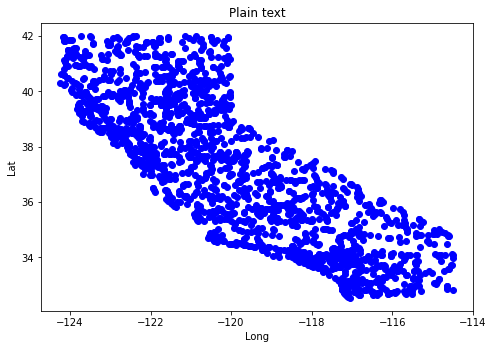

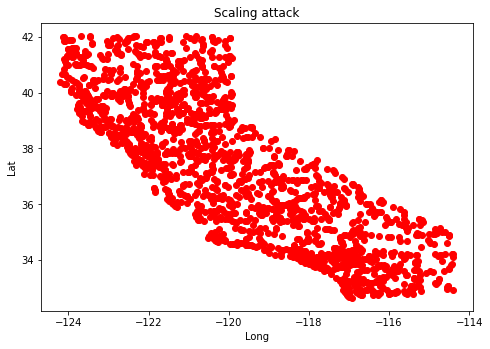

In [ ]:
import matplotlib.pyplot as plt

sample = data.sample(2000)

def plot_latlong(prefix='', prefix2='',c1='b', c2='r',t=''):
  fig=plt.figure()
  ax=fig.add_axes([0,0,1,1])
  ax.scatter(sample[prefix+'long'], sample[prefix+'lat'], color=c1)
  if prefix2:
    ax.scatter(sample[prefix2+'long'], sample[prefix2+'lat'], color=c2)
  ax.set_xlabel('Long')
  ax.set_ylabel('Lat')
  ax.set_title(t)
  plt.show()

plot_latlong('',t="Plain text")
plot_latlong('ScalingAtk_', c1='r', t="Scaling attack")

## Compute ScalingAtk error - geo distance between actual and predicted lat/long 

In [ ]:
#compute error
import geopy.distance

def distance(row, prefix):
  coords_1 = (row['lat'], row['long'])
  coords_2 = (row[prefix+'lat'], row[prefix+'long'])
  return geopy.distance.vincenty(coords_1, coords_2).km

data['ScalingAtk_Dist'] = data.progress_apply(lambda x: distance(x, 'ScalingAtk_'), axis=1)

In [ ]:
print("Distance error")
print()
data['ScalingAtk_Dist'].describe()

Distance error



count    21048.000000
mean        12.101984
std          2.379833
min          5.464222
25%         10.133830
50%         12.132814
75%         14.190149
max         16.998215
Name: ScalingAtk_Dist, dtype: float64

# Train model to correct error in ScalingAtk predictions

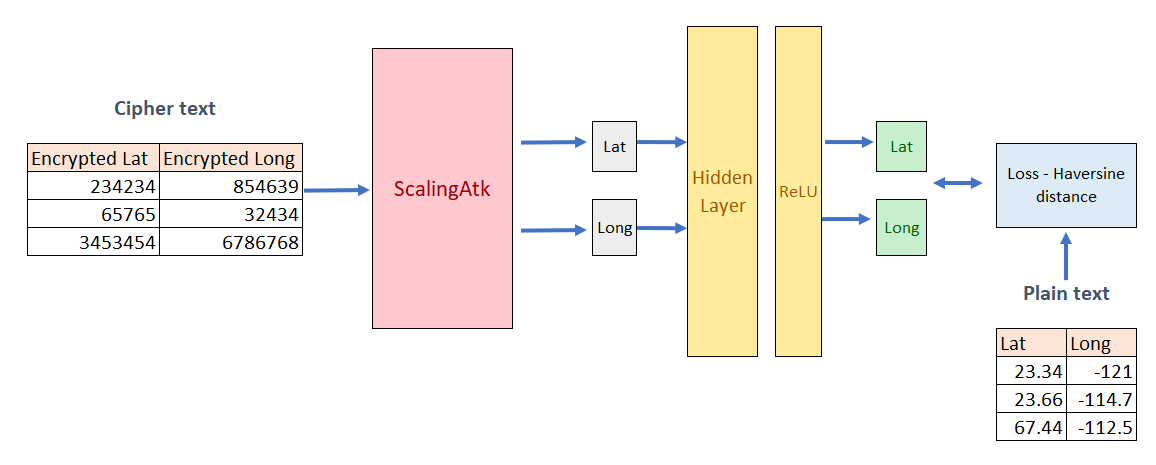

## Prepare datasets
1. Split data into train (40%), test (60%) data sets
2. Prepare data for batch training

In [ ]:
import torch
from sklearn.model_selection import train_test_split

class LatLong(torch.utils.data.Dataset):
    def __init__(self, df, xcolprefix='ScalingAtk_', ycolprefix=''):
        self.X = torch.tensor([[row[xcolprefix+'lat'], row[xcolprefix+'long']] for i, row in df.iterrows()], dtype=torch.float)
        self.Y = torch.tensor([[row[ycolprefix+'lat'], row[ycolprefix+'long']] for i, row in df.iterrows()], dtype=torch.float)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

TEST_SIZE=0.6
VALIDATION_SIZE=0.2

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, validation_df = train_test_split(train_df, test_size=VALIDATION_SIZE)

train_dataset = LatLong(train_df)
test_dataset = LatLong(test_df)
dev_dataset = LatLong(validation_df)

BATCH_SIZE=64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)

## Define multi layer perceptron

In [ ]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

model = MLP()
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)


## Loss & Optimizers

In [ ]:
import torch
import numpy as np
RADIUS_KM = 6378.1

def geo_distance(output, target):
    pi_on_180 = 0.0174532925239
    obv_rad = output*pi_on_180
    prev_rad = target*pi_on_180

    dlat_dlong = obv_rad - prev_rad 
    v = dlat_dlong / 2
    v = torch.sin(v)
    v = v**2

    a = v[:,0] + torch.cos(obv_rad[:,1]) * torch.cos(prev_rad[:,1]) * v[:,1] 

    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1-a))
    c = c*RADIUS_KM

    return c

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# can add geo loss
loss_fn = nn.SmoothL1Loss()
#loss_fn = geo_distance




## Backpropogation

In [ ]:
mean_train_losses = []
mean_valid_losses = []
epochs = 20

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (cipher, plaintext) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(cipher)
        loss = loss_fn(outputs, plaintext)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (i * 128) % (128 * 100) == 0:
            print(f'{i * 128} / 50000')
            
    model.eval()
    total=0
    dist=0
    cdist=0
    with torch.no_grad():
        for i, (cipher, plaintext) in enumerate(dev_dataloader):

            outputs = model(cipher)
            loss = loss_fn(outputs, plaintext)
            
            valid_losses.append(loss.item())
            
            out = outputs.numpy()
            pt = plaintext.numpy()
            ct = cipher.numpy()
            for i in range(len(out)):
              dist += geopy.distance.vincenty(pt[i], out[i]).km
              cdist += geopy.distance.vincenty(pt[i], ct[i]).km
              total += 1
                        
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f} valid average dist {:.4f} original {:.4f}'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), dist/total, cdist/total))
    


0 / 50000
12800 / 50000
epoch : 1, train loss : 27.3058, valid loss : 0.5251 valid average dist 155.9042 original 12.1283
0 / 50000
12800 / 50000
epoch : 2, train loss : 0.4943, valid loss : 0.4467 valid average dist 141.3625 original 12.1283
0 / 50000
12800 / 50000
epoch : 3, train loss : 0.4265, valid loss : 0.3813 valid average dist 127.4388 original 12.1283
0 / 50000
12800 / 50000
epoch : 4, train loss : 0.3624, valid loss : 0.3197 valid average dist 114.8477 original 12.1283
0 / 50000
12800 / 50000
epoch : 5, train loss : 0.2888, valid loss : 0.2479 valid average dist 98.2975 original 12.1283
0 / 50000
12800 / 50000
epoch : 6, train loss : 0.2108, valid loss : 0.1629 valid average dist 76.3872 original 12.1283
0 / 50000
12800 / 50000
epoch : 7, train loss : 0.1375, valid loss : 0.0978 valid average dist 58.2955 original 12.1283
0 / 50000
12800 / 50000
epoch : 8, train loss : 0.0783, valid loss : 0.0491 valid average dist 41.2549 original 12.1283
0 / 50000
12800 / 50000
epoch : 9, 

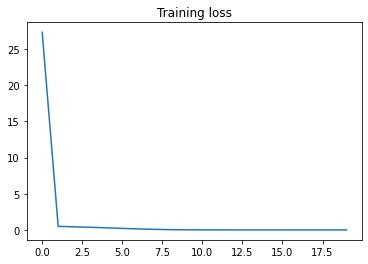

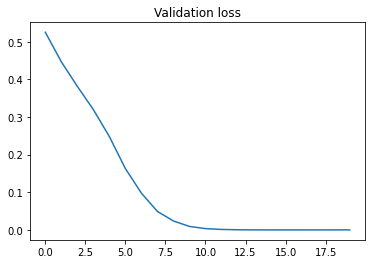

In [ ]:
plt.plot(mean_train_losses)
plt.title("Training loss")
plt.show()
plt.title("Validation loss")
plt.plot(mean_valid_losses)
plt.show()

In [ ]:
model.eval()
pred = model(test_dataset.X)
total = len(test_dataset)
dist=0
maxdist = dist
mindist = dist
for i in range(len(test_dataset)):
  d = geopy.distance.vincenty(test_dataset.Y[i], pred[i]).km
  maxdist = max(d, maxdist)
  mindist = min(d, mindist) 
  dist+=d
  total+=1

print("test dataset distance: average {:.4f}, min distance {:.4f}, max distance {:.4f}".format((dist/total), mindist, maxdist))

test dataset distance: average 1.0179, min distance 0.0000, max distance 6.1905


# Result- Error (distance from ground truth in km)

## ScalingAtk (From Paper)

1. Average distance - 12.10 km
2. Min distance - 5.46 km
3. Max distance - 16.99 km

## ScalingAtk with distance minimization (Experiment)

1. Average distance - 1.0179 km
2. Min distance - 0.0000 km
3. Max distance - 6.1905 km